<a href="https://colab.research.google.com/github/apmoore1/tdsa_comparisons/blob/master/analysis/TDSA_Baseline_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install -U git+git://github.com/apmoore1/target-extraction.git@master#egg=target-extraction

In [0]:
from collections import defaultdict
from typing import Dict, Any, Tuple, Callable, List

from target_extraction.data_types import TargetTextCollection
from target_extraction.analysis.util import metric_df, long_format_metrics, add_metadata_to_df, combine_metrics
from target_extraction.analysis.sentiment_metrics import accuracy, macro_f1
from target_extraction.analysis.statistical_analysis import one_tailed_p_value, find_k_estimator
import pandas as pd
import numpy as np
import seaborn as sns

def get_metric_results(collection: TargetTextCollection) -> pd.DataFrame:
  '''
  :param collection: Dataset that contains all of the results.
  :returns: A pandas dataframe with the following columns: `['prediction key', 
            'run number', 'Accuracy', 'Inter-Aspect', 'CWR', 'Position', 
            'Model', 'Macro F1', 'Dataset']`
  '''
  predicted_key = list(collection.metadata['predicted_target_sentiment_key'].keys())
  acc_df = metric_df(collection, accuracy, 'target_sentiments', predicted_key,
                     array_scores=True, assert_number_labels=3, 
                     metric_name='Accuracy', average=False, include_run_number=True)
  acc_df = add_metadata_to_df(acc_df, collection, 'predicted_target_sentiment_key')
  f1_df = metric_df(collection, macro_f1, 'target_sentiments', predicted_key,
                    array_scores=True, assert_number_labels=3, 
                    metric_name='Macro F1', average=False, include_run_number=True)
  combined_df = combine_metrics(acc_df, f1_df, 'Macro F1')
  combined_df['Dataset'] = [collection.name] * combined_df.shape[0]
  combined_df['Data Split'] = [collection.metadata['split']] * combined_df.shape[0]
  return combined_df

def metric_p_values(data_split_df: pd.DataFrame, better_split: str, 
                    compare_splits: List[str], datasets: List[str], 
                    metric_names_assume_normals: List[Tuple[str, bool]],
                    better_and_compare_column_name: str = 'Model',
                    long_form: bool = False
                    ) -> pd.DataFrame:
  '''
  :param data_split_df: The DataFrame that contains at least the following 
                        columns: 1. value for `better_and_compare_column_name`,
                        2. `Dataset`, 3. all `metric name`, and 4. `P-Values` 
  :param better_split: The name of the model you are testing if it is better
                       than all other models in the `compare_splits`
  :param compare_splits: The name of the models you assume are no different 
                         in score to the `better_split` model.
  :param datasets: Datasets to test the hypothesis on.
  :param metric_names_assume_normals: A list of Tuples that contain 
                                      (metric name, assumed to be normal)
                                      where the `assumed to be normal` is False 
                                      or True based on whether the metric scores 
                                      from `metric name` column can be assumed to be 
                                      normal or not. e.g. [(`Accuracy`, True)]
  :param better_and_compare_column_name: The column that contains the 
                                         `better_split` and `compare_splits` 
                                         values.
  :param long_form: Instead of having a p-value as a value to a dataset column 
                    their is a seperate `Dataset` 
  :returns: A DataFrame containing the following columns: 1. Metric, 2. Dataset,
            3. P-Value, 4. Compared {better_and_compare_column_name}, and 5.
            Better {better_and_compare_column_name}
  '''
  temp_df = data_split_df.copy(deep=True)
  better_df = temp_df[temp_df[f'{better_and_compare_column_name}']==f'{better_split}']
  
  compare_values = []
  better_values = []
  dataset_names = []
  metric_names = []
  p_values = []

  for compare_split in compare_splits:
    
    compare_df = temp_df[temp_df[f'{better_and_compare_column_name}']==f'{compare_split}']
    for dataset in datasets:
      better_dataset_df = better_df[better_df['Dataset']==dataset]
      compare_dataset_df = compare_df[compare_df['Dataset']==dataset]
      for metric_name, assume_normal in metric_names_assume_normals:
        better_scores = better_dataset_df[f'{metric_name}']
        compare_scores = compare_dataset_df[f'{metric_name}']
        p_value = one_tailed_p_value(better_scores, compare_scores, 
                                     assume_normal=assume_normal)
        
        p_values.append(p_value)
        metric_names.append(metric_name)
        dataset_names.append(dataset)
        compare_values.append(compare_split)
        better_values.append(better_split)
    
  return pd.DataFrame({f'Compared {better_and_compare_column_name}': compare_values, 
                       'Metric': metric_names, 'Dataset': dataset_names, 
                       'P-Value': p_values,
                       f'Better {better_and_compare_column_name}': better_values, })

def filter_df(df: pd.DataFrame, column_value: Dict[str, Any]) -> pd.DataFrame:
  filtered_df = df.copy(deep=True)
  for column_name, filter_value in column_value.items():
    filtered_df = filtered_df[filtered_df[f'{column_name}']==filter_value]
  return filtered_df

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

def reproduction_plot(test_df: pd.DataFrame) -> sns.axisgrid.FacetGrid:
  repro_test_df = test_df.drop(columns=['CWR', 'Position', 'prediction key', 
                                        'run number', 'Inter-Aspect', 'Data Split', 
                                        'Macro F1'])
  repro_test_df = repro_test_df[repro_test_df['Model']!='CNN']
  repro_test_df = repro_test_df[repro_test_df['Dataset']!='Election']
  repro_test_df['Accuracy'] = (repro_test_df['Accuracy'].round(4)) * 100
  model_names = ['IAN (O)', 'IAN (O)', 'TDLSTM (O)', 'TDLSTM (O)', 
                 'Att-AE (O)', 'Att-AE (O)']
  dataset_names = ['Laptop', 'Restaurant', 'Laptop', 'Restaurant', 
                   'Laptop', 'Restaurant']
  accuracies = [72.1, 78.6, 68.13, 75.63, 68.9, 76.6]
  originals_df = pd.DataFrame({'Model': model_names, 'Dataset': dataset_names, 
                               'Accuracy': accuracies})
  repro_test_df = repro_test_df.append(originals_df, ignore_index=True, 
                                       sort=False)
  
  model_order = ['IAN', 'IAN (O)', 'TDLSTM', 'TDLSTM (O)', 'Att-AE', 
                 'Att-AE (O)']

  return sns.catplot(x="Model", y='Accuracy', data=repro_test_df, col='Dataset',
                    kind='boxen', sharey=False,
                   order=model_order)


In [30]:
from pathlib import Path
import tempfile

import requests

# Get the data

result_base_url = Path('raw.githubusercontent.com/apmoore1/tdsa_'
                       'comparisons/master/saved_results/main/')
data_splits = ['test', 'val']
dataset_names = ['election', 'laptop', 'restaurant']

all_results: List[pd.DataFrame] = []

for data_split in data_splits:
  for dataset_name in dataset_names:
    data_url = Path(result_base_url, f'{dataset_name}_dataset', 
                    f'{data_split}.json')
    data_url = f'https://{str(data_url)}'
    with tempfile.TemporaryDirectory() as temp_dir:
      temp_file = Path(temp_dir, 'temp_file')
      response = requests.get(data_url, stream=True)
      with temp_file.open('wb+') as fp:
        for chunk in response.iter_content(chunk_size=128):
          fp.write(chunk)
      data_collection = TargetTextCollection.load_json(temp_file)
      all_results.append(get_metric_results(data_collection))

results_df = pd.concat(all_results, ignore_index=True)
test_result_df = results_df[results_df['Data Split']=='Test']
test_result_df = test_result_df.replace({'Model': 'AE'}, 'Att-AE')
val_result_df = results_df[results_df['Data Split']=='Validation']
val_result_df = val_result_df.replace({'Model': 'AE'}, 'Att-AE')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Baseline TDSA results

In this notebook we explore how the baseline models:
1. Perform in general i.e. overall accuracy and macro f1 scores
2. The perform of these models across the different error analysis splits

The baseline models used:
1. CNN Text classifier that has not knowledge of the target only the context. Model comes from [Kim 2014](https://www.aclweb.org/anthology/D14-1181/)
2. [**TDLSTM**](https://www.aclweb.org/anthology/C16-1311.pdf)
3. [**IAN**](https://www.ijcai.org/proceedings/2017/0568.pdf)
4. **Att-AE** (We called it *AE* when running the experiments and that is what it is called in the original data) -- A model that is the same as the *AE* model from [Wang et al. 2016](https://www.aclweb.org/anthology/D16-1058.pdf) but with an attention layer after the LSTM enocder. This model is also the same as the inter-aspect model (from now on called **Inter-AE**) from [Hazarika et al. 2018](https://www.aclweb.org/anthology/N18-2043/) but without the LSTM aspect encoder (phase 2 in figure 1) that models other targets from the same context/text. 

## Overall Performance

Here we show the difference in overall performance between the 4 classifiers, where all results will show the mean and standard deviation of the metric score from the 8 runs the model performed on the relevant dataset.

Before calculating those results we need to filter the results table so that it only shows the results for the baseline models and not for the enhanced models (enhanced models are those that either use Position informance, CWR, or Inter-Aspect encoding). Below shows the table of results un-filtered:

In [31]:
val_result_df

,prediction key,run number,Accuracy,Inter-Aspect,CWR,Model,Position,Macro F1,Dataset,Data Split
360,predicted_target_sentiment_IAN_GloVe_None_None,0,0.597173,False,False,IAN,False,0.473838,Election,Validation
361,predicted_target_sentiment_IAN_GloVe_None_None,1,0.605026,False,False,IAN,False,0.471042,Election,Validation
362,predicted_target_sentiment_IAN_GloVe_None_None,2,0.602670,False,False,IAN,False,0.445253,Election,Validation
363,predicted_target_sentiment_IAN_GloVe_None_None,3,0.603848,False,False,IAN,False,0.468502,Election,Validation
364,predicted_target_sentiment_IAN_GloVe_None_None,4,0.604633,False,False,IAN,False,0.473830,Election,Validation
...,...,...,...,...,...,...,...,...,...,...
715,predicted_target_sentiment_CNN_CWR_None_None,3,0.747302,False,True,CNN,False,0.639572,Restaurant,Validation
716,predicted_target_sentiment_CNN_CWR_None_None,4,0.747302,False,True,CNN,False,0.648986,Restaurant,Validation
717,predicted_target_sentiment_CNN_CWR_None_None,5,0.734712,False,True,CNN,False,0.641071,Restaurant,Validation
718,predicted_target_sentiment_CNN_CWR_None_None,6,0.741906,False,True,CNN,False,0.611305,Restaurant,Validation


Filtered results:

In [32]:
column_values = {'Inter-Aspect': False, 'Position': False, 'CWR': False}
filtered_val_df = filter_df(val_result_df, column_values)

column_values = {'Inter-Aspect': False, 'Position': False, 'CWR': False}
filtered_test_df = filter_df(test_result_df, column_values)

# Version of the DataFrame that are better suited for Plotting
combined_filtered_results = pd.concat([filtered_val_df, filtered_test_df])
plotting_filtered_df = long_format_metrics(combined_filtered_results, ['Accuracy', 'Macro F1'])

filtered_test_df

,prediction key,run number,Accuracy,Inter-Aspect,CWR,Model,Position,Macro F1,Dataset,Data Split
0,predicted_target_sentiment_IAN_GloVe_None_None,0,0.582841,False,False,IAN,False,0.448024,Election,Test
1,predicted_target_sentiment_IAN_GloVe_None_None,1,0.589138,False,False,IAN,False,0.457447,Election,Test
2,predicted_target_sentiment_IAN_GloVe_None_None,2,0.581267,False,False,IAN,False,0.414390,Election,Test
3,predicted_target_sentiment_IAN_GloVe_None_None,3,0.584416,False,False,IAN,False,0.445544,Election,Test
4,predicted_target_sentiment_IAN_GloVe_None_None,4,0.588745,False,False,IAN,False,0.452512,Election,Test
...,...,...,...,...,...,...,...,...,...,...
347,predicted_target_sentiment_CNN_GloVe_None_None,3,0.758036,False,False,CNN,False,0.598858,Restaurant,Test
348,predicted_target_sentiment_CNN_GloVe_None_None,4,0.762500,False,False,CNN,False,0.613384,Restaurant,Test
349,predicted_target_sentiment_CNN_GloVe_None_None,5,0.748214,False,False,CNN,False,0.571016,Restaurant,Test
350,predicted_target_sentiment_CNN_GloVe_None_None,6,0.757143,False,False,CNN,False,0.592415,Restaurant,Test


Now the results have been filtered to only values that have come from the relevant baseline models we can show the table of results.

Validation:

In [35]:
pd.pivot_table(filtered_val_df, index='Model', columns='Dataset', 
               values=['Macro F1', 'Accuracy'], 
               aggfunc={'Accuracy': mean_std, 
                        'Macro F1': mean_std}).T

Model                      Att-AE           CNN           IAN        TDLSTM
         Dataset                                                           
Accuracy Election    58.42 (0.40)  54.07 (0.56)  60.14 (0.40)  58.73 (0.38)
         Laptop      70.74 (0.75)  70.65 (0.68)  71.57 (0.64)  69.69 (0.63)
         Restaurant  71.99 (0.45)  72.31 (0.69)  72.13 (0.57)  72.43 (0.46)
Macro F1 Election    46.05 (1.85)  42.74 (2.09)  45.80 (1.48)  46.83 (1.80)
         Laptop      66.28 (1.21)  66.32 (0.96)  66.94 (1.32)  65.74 (1.00)
         Restaurant  60.77 (0.67)  60.51 (1.20)  60.84 (1.08)  61.63 (0.87)

Test

In [37]:
pd.pivot_table(filtered_test_df, index='Model', columns='Dataset', 
               values=['Macro F1', 'Accuracy'], 
               aggfunc={'Accuracy': mean_std, 
                        'Macro F1': mean_std}).T

Model                      Att-AE           CNN           IAN        TDLSTM
         Dataset                                                           
Accuracy Election    56.49 (0.76)  52.35 (0.69)  58.60 (0.36)  58.39 (0.74)
         Laptop      67.99 (1.30)  68.26 (0.69)  66.58 (0.53)  67.46 (1.60)
         Restaurant  76.62 (0.59)  75.81 (0.55)  76.51 (1.49)  76.09 (0.62)
Macro F1 Election    44.23 (1.81)  39.98 (2.20)  43.90 (1.52)  46.95 (2.33)
         Laptop      59.97 (2.29)  60.43 (1.36)  58.78 (0.62)  60.52 (2.63)
         Restaurant  61.01 (1.47)  59.40 (1.52)  61.22 (2.85)  61.59 (1.57)

These results can be better seen in the following plot:

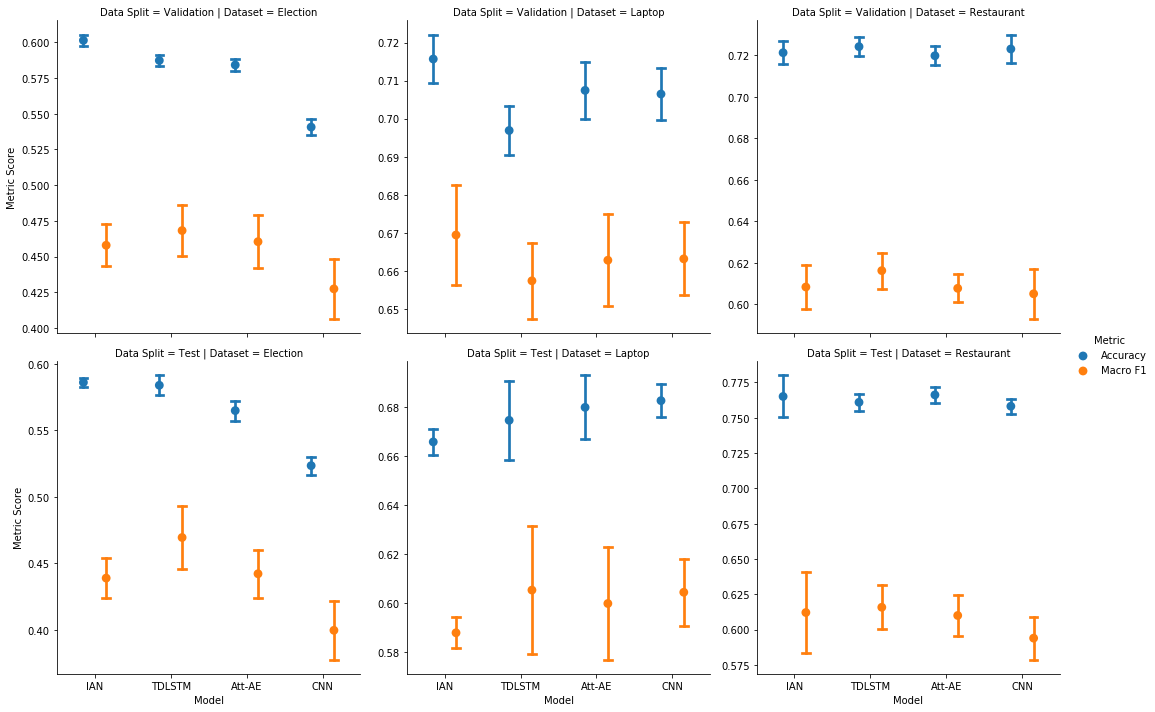

In [8]:
sns.catplot(x='Model', y='Metric Score', hue='Metric', data=plotting_filtered_df, 
            kind='point', col='Dataset', ci='sd', join=False, capsize=.1,
            dodge=0.3, sharey=False, row='Data Split')

From both the plot and the table of results the main finding is that a text classification model is a very strong baseline as shown by [Tang et al. 2016](https://www.aclweb.org/anthology/D16-1021/), [Wang et al. 2016](https://www.aclweb.org/anthology/D16-1058.pdf), [He et al. 2018](https://www.aclweb.org/anthology/P18-2092/), and [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/). The only dataset that the *CNN* model performs a lot worse on is the Election dataset, of which this is most likely due to the Election dataset having the least number of samples that contain only one unique sentiment.

All of the TDSA models were compared to a LSTM text classsification baseline in there original papers and follow up paper for the [TDLSTM](https://www.aclweb.org/anthology/D16-1021/). However this text classification baseline was never explained fully, as in the way that the baseline was trained. The baseline could have been trained at least in 3 different ways: 

1. Use all of the samples even if the samples sentiment contradicted each other.
2. Only use samples where the text contain only has one unique sentiment.
3. Take the sentiment of the majority class for each text and thus use all of the samples where a sample here is a text rather than a target as is the case in version 1 of this list.

For our *CNN* baseline we use method 3. However as each of these method main encoders are *LSTM* based and [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) showed on the Restaurant dataset that the *CNN* is a stronger text classification baseline we have applied the *CNN* to two more datasets than [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) showing that *CNN* can be a powerful baseline for the Laptop datasets as well and for the Macro F1 metric as [Jiang et al. 2019](https://www.aclweb.org/anthology/D19-1654/) only evaluated on the Accuracy metric.

Below we also compare the original methods results from the relevant papers to ours (only show accuracy scores as none of the original papers report macro f1 scores). The scores for the original methods are those with the (O) after the model name:

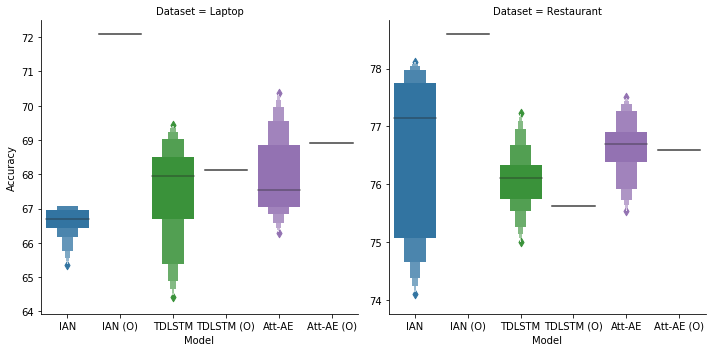

In [9]:
reproduction_plot(filtered_test_df)

As we can see from the graph only IAN we do not get similar scores to the original paper, we believe this is due to the use of a different optimiser as in the original paper they use Stochastic Gradient Descent with momentum where as we use ADAM.


#### Are the TDSA methods statistically significantly better than a Text Classifier
From these results we test to see if any of the TDSA classifiers are statistically signficantly better than the text classifier (*CNN*). None of the original papers test for statistical significance as they only show that their new method is better than the text classification baseline. Furthermore the text classification baseline also always used the same encoder (LSTM) as the new TDSA method they created. The table below states the number of TDSA models out of the 3 which are statistically significantly better than *CNN* model:

In [15]:
def p_value_count(alpha: float) -> Callable[[pd.Series], float]:
  def alpha_count(p_values: pd.Series) -> float:
    significant_p_values = p_values <= alpha
    return np.sum(significant_p_values)
  return alpha_count

alpha = 0.05
metric_assumed_normal = [('Accuracy', True), ('Macro F1', True)]
dataset_names = ['Laptop', 'Restaurant', 'Election']
tdsa_model_names = ['TDLSTM', 'Att-AE', 'IAN']
all_p_values = []
for split_name, data_df in [('Validation', filtered_val_df), ('Test', filtered_test_df)]:
  for tdsa_model_name in tdsa_model_names:
    p_value_df = metric_p_values(data_df, f'{tdsa_model_name}', ['CNN'], 
                                 dataset_names, metric_assumed_normal)
    p_value_df['Split'] = split_name
    all_p_values.append(p_value_df)
combined_cnn_p_values = pd.concat(all_p_values, sort=False, ignore_index=True)
pd.pivot_table(data=combined_cnn_p_values, values='P-Value', columns='Dataset', 
               index=['Split', 'Metric'], aggfunc=p_value_count(alpha))


Dataset              Election  Laptop  Restaurant
Split      Metric                                
Test       Accuracy       3.0     0.0         1.0
           Macro F1       3.0     0.0         2.0
Validation Accuracy       3.0     1.0         0.0
           Macro F1       3.0     0.0         1.0

Below we show the exact P-Values for each model across the datasets and evaluation metrics:

In [27]:
pd.pivot_table(data=combined_cnn_p_values, values='P-Value', columns='Dataset', 
               index=['Better Model' ,'Split', 'Metric'])

Dataset                               Election    Laptop  Restaurant
Better Model Split      Metric                                      
Att-AE       Test       Accuracy  2.147997e-08  0.683750    0.009696
                        Macro F1  7.860032e-04  0.671443    0.032267
             Validation Accuracy  2.578713e-10  0.402771    0.841210
                        Macro F1  3.760008e-03  0.524136    0.311463
IAN          Test       Accuracy  2.213951e-10  0.999907    0.139068
                        Macro F1  1.023495e-03  0.992310    0.082932
             Validation Accuracy  3.981701e-12  0.010289    0.698269
                        Macro F1  3.964224e-03  0.164457    0.300675
TDLSTM       Test       Accuracy  1.292512e-10  0.873634    0.194028
                        Macro F1  2.533185e-05  0.468924    0.009524
             Validation Accuracy  1.268846e-10  0.991967    0.363793
                        Macro F1  8.076217e-04  0.855627    0.034230

As shown the Election dataset across the two metrics is the only dataset where all 3 TDSA methods are better than the standard text classifier (*CNN*). This is most likley due to what was stated before, that the Election dataset having the least number of samples that contain only one unique sentiment.

Furthermore below we apply the Bonferroni correction to the P-Values after being broken down by metric and split:

In [13]:
for split_name in ['Test', 'Validation']:
  split_cnn_p_values = combined_cnn_p_values[combined_cnn_p_values['Split']==split_name]
  for metric_name in ['Accuracy', 'Macro F1']:
    metric_cnn_p_values = split_cnn_p_values[split_cnn_p_values['Metric']==metric_name]
    num_sig_tests = len(metric_cnn_p_values)
    p_value_correction = find_k_estimator(metric_cnn_p_values['P-Value'], 
                                          alpha=alpha, method='B')
    print(f'For the {split_name} split the TDSA methods are statistically significantly '
          f'better than the CNN model on {p_value_correction} out of the {num_sig_tests}'
          f' significance tests when evaluated using the {metric_name} metric.')


For the Test split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Accuracy metric.
For the Test split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Macro F1 metric.
For the Validation split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Accuracy metric.
For the Validation split the TDSA methods are statistically significantly better than the CNN model on 3 out of the 9 significance tests when evaluated using the Macro F1 metric.


As stated only 3 of the evaluations out of the 9 for each split and metric are significant after the Bonferroni correction has been applied.

## Performance of the models when broken down into different error splits

The different error splits that will be explored are the following:
1. Distinct Sentiment (*DS*)
2. Number Targets (*NT*)
3. Target Sentence Sentiment Ratio (*TSSR*)
4. *n-shot*
5. Target Sentiment Relation (*TSR*)

Of which error splits 1, 2, and 3 are local where as the rest are global.

### *DS*
